### Домашнее задание к лекции 1

<ol>
    <li>Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?</li>
</ol>

In [5]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [6]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

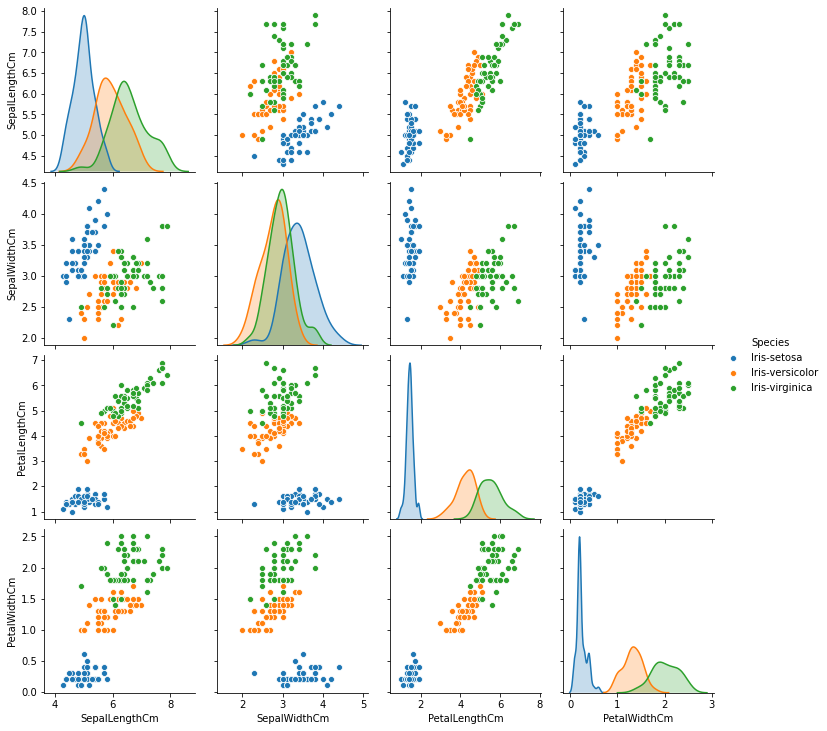

In [7]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(np.array(x))

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = np.array(y)
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [94]:
### Шаг 3. Обученние нейронной сети

def training_nn(X_train, y_train, neuron_numb = 5, n = 0.1, n_iter = 3000, plot=0):
    # определим число нейронов скрытого слоя
    # скорость обучения (learning rate)
    # присваевание случайных весов
    
    model = {}
    
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 5 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода
    # массив для ошибок, чтобы потом построить график
    errors = []
    # процесс обучения
    for i in range(n_iter):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        
    model['last_layer']=layer2
    model['w0']=w0
    model['w1']=w1
    model['errors']=errors
    model['accuracy']=accuracy
    
    if plot == 1:
        ### Шаг 4. Демонстрация полученных результатов
        # черчение диаграммы точности в зависимости от обучения
        plt.figure(figsize = (16,5))
        plt.plot(model['errors'])
        plt.xlabel('Обучение')
        plt.ylabel('Ошибка')
        plt.show() # расскоментируйте, чтобы посмотреть 

        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(model['last_layer'][:N,1], 'r',label = 'Y new')
        plt.plot(y_train[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() # расскоментируйте, чтобы посмотреть 
        print("Точность нейронной сети на трейне: " + str(round(model['accuracy'],2)) + "%")
    

    return model


def test_nn(X_test, y_test, model, plot=0):
    # прямое распространение(feed forward)
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, model['w0']))
    layer2_t = sigmoid(np.dot(layer1_t, model['w1']))
    layer2_error_t = y_test - layer2_t
    
    # метрика модели
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100
    
    if plot == 1:
        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(layer2_t[:N,1], 'r',label = 'Y new')
        plt.plot(y_test[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() # расскоментируйте, чтобы посмотреть
        print("Точность нейронной сети на тесте: " + str(round(accuracy_t,2)) + "%")
        
    return accuracy_t


In [58]:
model1 = training_nn(X_train, y_train, neuron_numb = 5, n = 0.05, n_iter = 5000)

Точность нейронной сети на трейне: 97.03%


In [60]:
test_nn(X_test, y_test, model1);

Точность нейронной сети на тесте: 96.3%


In [87]:
neuron_numb = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30]
learning_rate = [0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
n_iter = [1000, 3000, 5000, 10000, 15000, 30000]
# greed = {'neuron_numb': neuron_numb,
#             'learning_rate': learning_rate,
#             'n_iter': n_iter}

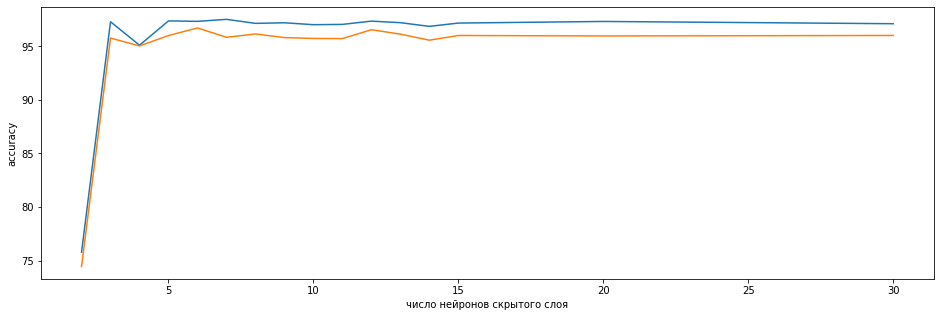

In [85]:
# зависимость точности от числа нейронов в скрытом слое
train_accuracy = []
test_accuracy = []
for i in neuron_numb:
    model = training_nn(X_train, y_train, neuron_numb = i, n = 0.1, n_iter = 5000)
    train_accuracy.append([i, model['accuracy']])
    test_accuracy.append([i, test_nn(X_test, y_test, model)])
plt.figure(figsize = (16,5))
plt.plot(np.array(train_accuracy)[:,0], np.array(train_accuracy)[:,1], label = 'train')
plt.plot(np.array(test_accuracy)[:,0], np.array(test_accuracy)[:,1],label = 'test')
plt.xlabel('число нейронов скрытого слоя')
plt.ylabel('accuracy')
plt.show() 

<ipython-input-6-6fc1c38edf69>:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


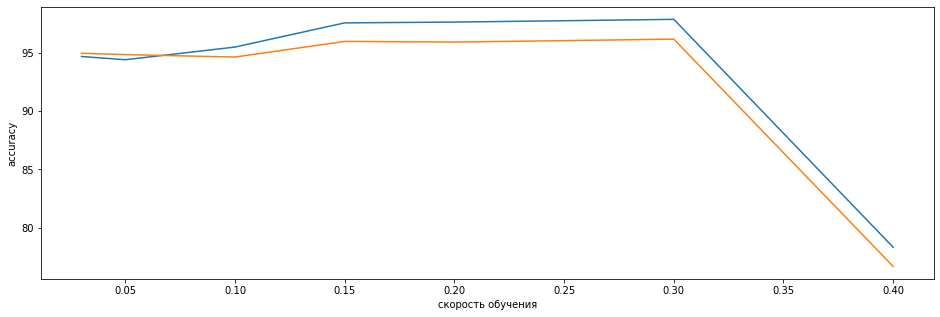

In [92]:
# зависимость точности от скорости обучения
train_accuracy = []
test_accuracy = []
for i in learning_rate:
    model = training_nn(X_train, y_train, neuron_numb = 5, n = i, n_iter = 5000)
    train_accuracy.append([i, model['accuracy']])
    test_accuracy.append([i, test_nn(X_test, y_test, model)])
plt.figure(figsize = (16,5))
plt.plot(np.array(train_accuracy)[:,0], np.array(train_accuracy)[:,1], label = 'train')
plt.plot(np.array(test_accuracy)[:,0], np.array(test_accuracy)[:,1],label = 'test')
plt.xlabel('скорость обучения')
plt.ylabel('accuracy')
plt.show() 

<ipython-input-6-6fc1c38edf69>:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


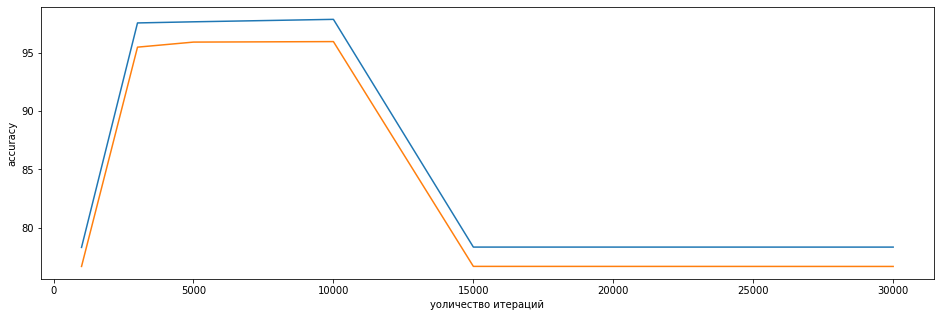

In [93]:
# зависимость точности от количества итераций
train_accuracy = []
test_accuracy = []
for i in n_iter:
    model = training_nn(X_train, y_train, neuron_numb = 5, n = 0.3, n_iter = i)
    train_accuracy.append([i, model['accuracy']])
    test_accuracy.append([i, test_nn(X_test, y_test, model)])
plt.figure(figsize = (16,5))
plt.plot(np.array(train_accuracy)[:,0], np.array(train_accuracy)[:,1], label = 'train')
plt.plot(np.array(test_accuracy)[:,0], np.array(test_accuracy)[:,1],label = 'test')
plt.xlabel('уоличество итераций')
plt.ylabel('accuracy')
plt.show() 

Как видим, точность самая высокая при следующих параметрах:
neuron_numb = 5
learning_rate = 0.03
n_iter = 10000

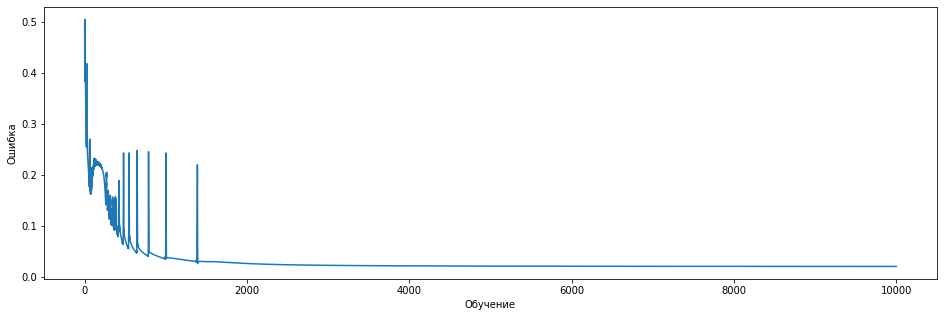

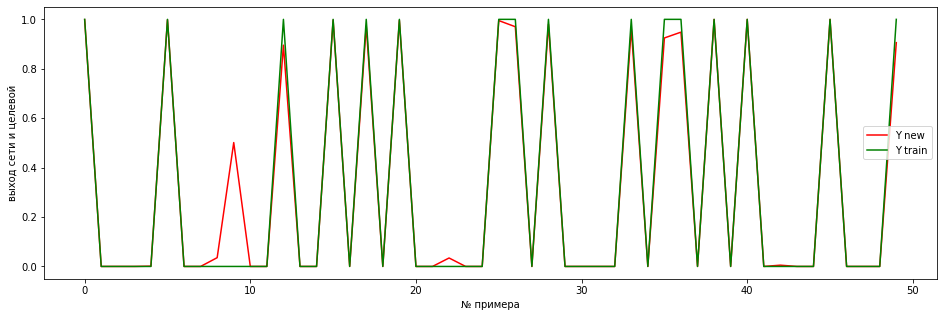

Точность нейронной сети на трейне: 97.92%


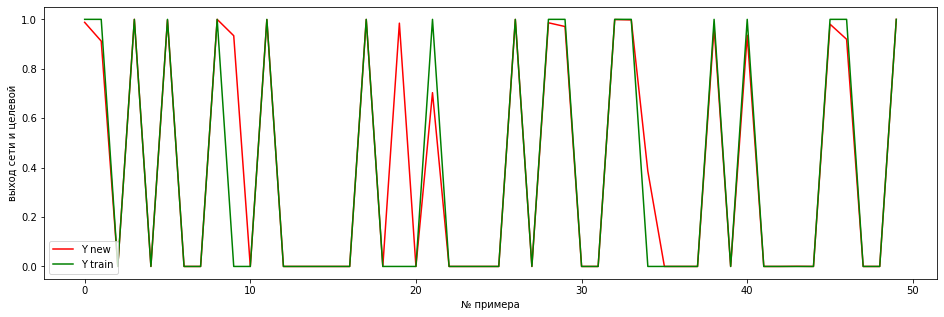

Точность нейронной сети на тесте: 96.05%


In [97]:
best_model = training_nn(X_train, y_train, neuron_numb = 5, n = 0.3, n_iter = 10000, plot = 1)
test_nn(X_test, y_test, best_model, plot = 1);

Еще результат зависит от первоначальных весов